In [15]:
import tqdm
import numpy as np
from matplotlib import pyplot as plt

import cv2 as cv
import os
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [12]:
### PLOT ONE SAMPLE OF IMAGE IN THE DATA ###
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

original = cv.imread('original77.jpg')
original = cv.resize(original,(224,224))
dress = cv.imread('dress77.jpg')
dress = cv.resize(dress,(224,224))
body = cv.imread('body77.jpg')
body = cv.resize(body,(224,224))

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(cv.cvtColor(original, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,2)
plt.title('Person')
plt.imshow(cv.cvtColor(body, cv.COLOR_BGRA2RGB))
plt.subplot(1,3,3)
plt.title('Dress')
plt.imshow(cv.cvtColor(dress, cv.COLOR_BGRA2RGB))

AttributeError: module 'tensorflow' has no attribute 'Session'

In [ ]:
dress = cv.imread('dress77.jpg',0)
body = cv.imread('body77.jpg',0)

### ENCODE DRESS ###
dress[dress == 255] = 0
dress[dress > 0] = 255
dress = cv.resize(dress,(224,224))

### ENCODE BODY ###
body[body == 255] = 0
body[body > 0] = 255
body = cv.resize(body,(224,224))

### ENCODE SKIN ###
skin = body - dress


plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.title('Person/Background')
bg = (255 - body)/255
plt.imshow(bg)
plt.subplot(1,3,2)
plt.title('Skin')
skin = (255 - skin)/255
plt.imshow(skin)
plt.subplot(1,3,3)
plt.title('Dress')
dress = (255 - dress)/255
plt.imshow(dress)

Error in callback <function flush_figures at 0x000002B07153BEA0> (for post_execute):


KeyboardInterrupt: 

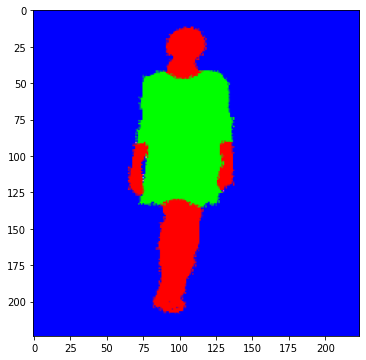

In [ ]:
### COMBINE BACKGROUND, SKIN, DRESS ###

gt = np.zeros((224,224,3))
gt[:,:,0] = (1-skin)
gt[:,:,1] = (1-dress)
gt[:,:,2] = bg

plt.figure(figsize=(6,6))
plt.imshow(gt)

In [ ]:
### ENCODE BACKGROUND, SKIN, DRESS FOR ALL TRAIN IMAGES ###

images_original = []
images_gt = []

mean = np.zeros((224,224,3))
n_img = 77

for i in tqdm.tqdm(range(1,n_img+1)):
    
    original = cv.imread('./original77.jpg')
    original = cv.resize(original,(224,224))
    images_original.append(original)
    mean[:,:,0]=mean[:,:,0]+original[:,:,0]
    mean[:,:,1]=mean[:,:,1]+original[:,:,1]
    mean[:,:,2]=mean[:,:,2]+original[:,:,2]
    
    body = cv.imread('./body77.jpg',0)
    dress = cv.imread('./dress77.jpg',0)
    
    dress[dress == 255] = 0
    dress[dress > 0] = 255
    dress = cv.resize(dress,(224,224))

    body[body == 255] = 0
    body[body > 0] = 255
    body = cv.resize(body,(224,224))

    skin = body - dress
    bg = (255 - body)/255
    skin = (255 - skin)/255
    dress = (255 - dress)/255
    
    gt = np.zeros((224,224,3))
    gt[:,:,0] = (1-skin)
    gt[:,:,1] = (1-dress)
    gt[:,:,2] = bg
   
    images_gt.append(gt)

mean = mean / n_img
mean = mean.reshape((-1,224,224,3))

images_original = np.asarray(images_original)
images_gt = np.asarray(images_gt)

100%|██████████| 77/77 [00:01<00:00, 54.37it/s]


In [ ]:
def get_unet(mean_pixels, do_rate=0):
  
    inputs = Input((None, None, 3))
    preproc = Lambda(lambda x: (x - tf.constant(mean_pixels, dtype=tf.float32)))(inputs) 

    conv1 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(preproc))
    conv1 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(conv1))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(pool1))
    conv2 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(conv2))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(pool2))
    conv3 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(conv3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(pool3))
    conv4 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(conv4))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do_rate)(Conv2D(512, (3, 3), padding='same', activation='relu')(pool4))
    conv5 = Dropout(do_rate)(Conv2D(512, (3, 3), padding='same', activation='relu')(conv5))

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(up6))
    conv6 = Dropout(do_rate)(Conv2D(256, (3, 3), padding='same', activation='relu')(conv6))

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(up7))
    conv7 = Dropout(do_rate)(Conv2D(128, (3, 3), padding='same', activation='relu')(conv7))

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(up8))
    conv8 = Dropout(do_rate)(Conv2D(64, (3, 3), padding='same', activation='relu')(conv8))

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(up9))
    conv9 = Dropout(do_rate)(Conv2D(32, (3, 3), padding='same', activation='relu')(conv9))

    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = get_unet(mean)
model.fit(images_original, images_gt, epochs=120)

c:\Users\xus\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/120
3/3 [==============================] - 30s 9s/step - loss: 0.6929 - accuracy: 0.5163
Epoch 2/120
3/3 [==============================] - 30s 9s/step - loss: 0.6917 - accuracy: 0.8401
Epoch 3/120
3/3 [==============================] - 28s 8s/step - loss: 0.6905 - accuracy: 0.8401
Epoch 4/120
3/3 [==============================] - 30s 9s/step - loss: 0.6893 - accuracy: 0.8401
Epoch 5/120
3/3 [==============================] - 33s 9s/step - loss: 0.6882 - accuracy: 0.8401
Epoch 6/120


KeyboardInterrupt: 

In [ ]:
### SAVE TRAINED MODEL ###

model.save('./fashion_unet.h5')